<a href="https://colab.research.google.com/github/Joovvhan/ColabTest/blob/master/notebooks/CTC_best_result_on_Colab_failure_case.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torch.nn as nn
from torch import optim
from torch.autograd import Variable

import os
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import librosa
import random
import copy

from tqdm import tqdm_notebook as tqdm
from datetime import datetime

In [27]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [3]:
n_mels = 80
fs = 44100
frame_length_ms=50
frame_shift_ms=25
nsc = int(fs * frame_length_ms / 1000)
nov = nsc - int(fs * frame_shift_ms / 1000)
nhop = int(fs * frame_shift_ms / 1000)
eps = 1e-8
db_ref = 160

meta_path = 'gdrive/My Drive/korean-single-speaker-speech-dataset/transcript.v.1.2.txt'
data_folder = 'gdrive/My Drive/korean-single-speaker-speech-dataset/kss'


with open(meta_path, encoding='utf-8') as f:
    metadata = np.array([line.strip().split('|') for line in f])
#     hours = sum((int(x[2]) for x in metadata)) * frame_shift_ms / (3600 * 1000)
#     log('Loaded metadata for %d examples (%.2f hours)' % (len(metadata), hours))

# metadata = metadata[:32, :2]

max_sequence_len = max(list(map(len, metadata[:, 1])))

error_jamos = [5868, 5998, 6046, 6155, 6202, 
               6654, 6890, 7486, 7502, 7744, 
               7765, 8267, 9069, 9927, 10437, 
               10515, 10533, 10606, 10610, 12777]

print(metadata.shape)
metadata = np.delete(metadata, error_jamos, axis = 0)
print(metadata.shape)

dataset_size = len(metadata)

(12853, 5)
(12833, 5)


In [0]:
character_length = list()
file_length = list()
division_length = list()
unicode_jamo_list = list()

for i in range(len(metadata)):
    character_length.append(len(metadata[i, 3]))
    file_length.append(float(metadata[i, 4]))
    division_length.append(float(metadata[i, 4]) * 1000 / len(metadata[i, 3]))

In [0]:
wave_name_list = []

for data in metadata:
    wave_name_list.append(data[0])

In [6]:
unicode_jamo_list = list()
for unicode in range(0x1100, 0x1113):
    unicode_jamo_list.append(chr(unicode))
    
for unicode in range(0x1161, 0x1176):
    unicode_jamo_list.append(chr(unicode))
    
for unicode in range(0x11A8, 0x11C3):
    unicode_jamo_list.append(chr(unicode))
    
unicode_jamo_list += [' ', '!', ',', '.', '?', '<sos>', '<eos>']
    
unicode_jamo_list.sort()

unicode_jamo_list = ['-'] + unicode_jamo_list

print(unicode_jamo_list)
print(len(unicode_jamo_list))

['-', ' ', '!', ',', '.', '<eos>', '<sos>', '?', 'ᄀ', 'ᄁ', 'ᄂ', 'ᄃ', 'ᄄ', 'ᄅ', 'ᄆ', 'ᄇ', 'ᄈ', 'ᄉ', 'ᄊ', 'ᄋ', 'ᄌ', 'ᄍ', 'ᄎ', 'ᄏ', 'ᄐ', 'ᄑ', 'ᄒ', 'ᅡ', 'ᅢ', 'ᅣ', 'ᅤ', 'ᅥ', 'ᅦ', 'ᅧ', 'ᅨ', 'ᅩ', 'ᅪ', 'ᅫ', 'ᅬ', 'ᅭ', 'ᅮ', 'ᅯ', 'ᅰ', 'ᅱ', 'ᅲ', 'ᅳ', 'ᅴ', 'ᅵ', 'ᆨ', 'ᆩ', 'ᆪ', 'ᆫ', 'ᆬ', 'ᆭ', 'ᆮ', 'ᆯ', 'ᆰ', 'ᆱ', 'ᆲ', 'ᆳ', 'ᆴ', 'ᆵ', 'ᆶ', 'ᆷ', 'ᆸ', 'ᆹ', 'ᆺ', 'ᆻ', 'ᆼ', 'ᆽ', 'ᆾ', 'ᆿ', 'ᇀ', 'ᇁ', 'ᇂ']
75


In [0]:
class Tokenizer():
    def __init__(self, vocabs):
        self.vocabs = vocabs
        
    def word2num(self, sentence):
        tokens = list()
        for char in sentence:
            tokens.append(self.vocabs.index(char))    
        return tokens
        
    def word2vec(self, sentence):
        vectors = np.zeros((len(sentence), len(self.vocabs)))
        for i, char in enumerate(sentence):
            vectors[i, self.vocabs.index(char)] = 1   
        return vectors
    
    def num2word(self, num):
        output = list()
        for i in num:
            output.append(self.vocabs[i])
        return output
    
    def num2vec(self, numbers):
        vectors = np.zeros((len(numbers), len(self.vocabs)))
        for i, num in enumerate(numbers):
            vectors[i, num] = 1   
        return vectors

In [0]:
tokenizer = Tokenizer(unicode_jamo_list)
jamo_tokens = tokenizer.word2num(unicode_jamo_list)

In [9]:
mel_path_list = list()

for i, wav_name in enumerate(tqdm(wave_name_list)):
    
    npy_name = wav_name.replace('.wav', '.npy')
    wav_path = os.path.join(data_folder, wav_name)  
    mel_path = os.path.join(data_folder + '/mel', npy_name)
    mel_path_list.append(mel_path)
    
    if not os.path.isfile(mel_path):
#         print("{}".format(mel_path))
        y, sr = librosa.core.load(wav_path)
        f, t, Zxx = sp.signal.stft(y, fs=sr, nperseg=nsc, noverlap=nov)
        Sxx = np.abs(Zxx)
        Sxx = np.maximum(Sxx, eps)

        # plt.figure(figsize=(20,20))
        # plt.imshow(20*np.log10(Sxx), origin='lower')
        # plt.colorbar()
        # plt.show()

        mel_filters = librosa.filters.mel(sr=fs, n_fft=nsc, n_mels=n_mels)
        mel_specgram = np.matmul(mel_filters, Sxx)

    #   log_specgram = 20*np.log10(Sxx)
    #   norm_log_specgram = (log_specgram + db_ref) / db_ref

        log_mel_specgram = 20 * np.log10(np.maximum(mel_specgram, eps))
        norm_log_mel_specgram = (log_mel_specgram + db_ref) / db_ref

    #   np.save(specgram_path, norm_log_specgram)
        np.save(mel_path, norm_log_mel_specgram)
    #   np.save(specgram_path, Sxx)

    #     print(norm_log_mel_specgram.shape[1])

    #     if i % 1000 == 0:
    #         plt.figure(figsize=(8, 4))
    #         plt.imshow(20 * np.log10(Sxx), origin='lower', aspect='auto')
    #         plt.colorbar()
    #         plt.show()

    #         plt.figure(figsize=(8, 4))
    #         plt.imshow(norm_log_mel_specgram, origin='lower', aspect='auto')
    #         plt.colorbar()
    #         plt.show()    

In [0]:
class ResidualGRU(nn.Module):
    def __init__(self, D_in, bidirectional=True):
        super(ResidualGRU, self).__init__()
        self.gru = nn.GRU(D_in, int(D_in/2), bidirectional=bidirectional, batch_first=True)
        self.relu = nn.ReLU()
        
    def forward(self, input_tensor):
        
#         print("Residual Input: {}".format(input_tensor.shape))
        gru_output, _ = self.gru(input_tensor)
        activated = self.relu(gru_output)  
#         print("Residual Output: {}".format(activated.shape))
        output_tensor = torch.add(activated, input_tensor)
        
        return output_tensor

In [0]:
class Encoder(nn.Module):
    def __init__(self, D_in, H):
        super(Encoder, self).__init__()
        self.H = H
        
        self.fc = torch.nn.Linear(D_in, H)
        self.relu = torch.nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
        
        self.gru = nn.GRU(H, int(H/2), bidirectional=True, batch_first=True)

    def forward(self, input_tensor):
            
        output_tensor = self.fc(input_tensor)
        output_tensor = self.relu(output_tensor)
        output_tensor = self.dropout(output_tensor)
        
        output_tensor, _ = self.gru(output_tensor)
        
        return output_tensor
    
class CTC_Decoder(nn.Module):
    def __init__(self, H, D_out):
        super(CTC_Decoder, self).__init__()
        self.H = H
        
        self.fc_embed = nn.Linear(H, H)
        self.relu_embed = torch.nn.ReLU()
        self.dropout_embed = nn.Dropout(p=0.5)
        
        self.gru = nn.GRU(H, D_out, batch_first=True)
        
        self.fc = nn.Linear(D_out, 75)
        self.log_softmax = nn.LogSoftmax(dim=2)

    def forward(self, input_tensor):

        output_tensor = self.fc_embed(input_tensor)
        output_tensor = self.relu_embed(output_tensor)
        output_tensor = self.dropout_embed(output_tensor)
        
        output_tensor,_ = self.gru(input_tensor)

        output_tensor = self.fc(output_tensor)
        
        prediction_tensor = self.log_softmax(output_tensor)

        return prediction_tensor

class Mel2SeqNet():
    def __init__(self, D_in, H, D_out):
        super(Mel2SeqNet, self).__init__()
        
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        
        self.H = H
        
        self.encoder = Encoder(D_in, H).to(device)
        self.embedding_layer = nn.Embedding(len(jamo_tokens), 256).to(device)
        self.decoder = CTC_Decoder(H, D_out).to(device)

        self.encoder_optimizer = optim.Adam(self.encoder.parameters(), lr=0.001)
        self.decoder_optimizer = optim.Adam(self.decoder.parameters(), lr=0.001)
        self.embedding_optimizer = optim.Adam(self.embedding_layer.parameters(), lr=0.001)

#         self.criterion = nn.CrossEntropyLoss(reduction='none').to(device)
        self.ctc_loss = nn.CTCLoss().to(device)
        
        for param in self.encoder.parameters():
            param.data.uniform_(-0.1, 0.1)
        for param in self.embedding_layer.parameters():
            param.data.uniform_(-0.1, 0.1)
        for param in self.decoder.parameters():
            param.data.uniform_(-0.1, 0.1)

    def train(self, input_tensor, ground_truth, loss_mask, target_lengths):
        
        batch_size = input_tensor.shape[0]

        self.encoder_optimizer.zero_grad()
        self.decoder_optimizer.zero_grad()
        self.embedding_optimizer.zero_grad()

        encoded_tensor = self.encoder(input_tensor)

        pred_tensor = self.decoder(encoded_tensor)
            
        truth = ground_truth
        truth = truth.type(torch.cuda.LongTensor)
        
        pred_tensor = pred_tensor.permute(1, 0, 2)
        
        input_lengths = torch.full(size=(batch_size,), fill_value=pred_tensor.shape[0], dtype=torch.long)
        
#         print(pred_tensor)

        loss = self.ctc_loss(pred_tensor, truth, input_lengths, target_lengths)

        loss.backward()

        self.encoder_optimizer.step()
        self.decoder_optimizer.step()
        self.embedding_optimizer.step()
        
        return pred_tensor, loss.item() / ground_truth.shape[1]
    
    def save(self, check_point_name):
        torch.save({
            'embedding_layer_state_dict': self.embedding_layer.state_dict(),
            'encoder_state_dict': self.encoder.state_dict(),
            'decoder_state_dict': self.decoder.state_dict(),
            'embedding_optimizer_state_dict': self.embedding_optimizer.state_dict(),
            'encoder_optimizer_state_dict': self.encoder_optimizer.state_dict(),
            'decoder_optimizer_state_dict': self.decoder_optimizer.state_dict(),
            }, check_point_name)
    
    def load(self, check_point_name):
        checkpoint = torch.load(check_point_name)
        self.embedding_layer.load_state_dict(checkpoint['embedding_layer_state_dict'])
        self.encoder.load_state_dict(checkpoint['encoder_state_dict'])
        self.decoder.load_state_dict(checkpoint['decoder_state_dict'])
        self.embedding_optimizer.load_state_dict(checkpoint['embedding_optimizer_state_dict'])
        self.encoder_optimizer.load_state_dict(checkpoint['encoder_optimizer_state_dict'])
        self.decoder_optimizer.load_state_dict(checkpoint['decoder_optimizer_state_dict'])
    
        self.embedding_layer.eval()
        self.encoder.eval()
        self.decoder.eval()
        
        self.embedding_layer.train()
        self.encoder.train()
        self.decoder.train()
    
# net = Mel2SeqNet(80, 512, 256)

net = Mel2SeqNet(80, 1024, 512)

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")      
print(device)

cuda:0


In [0]:
class Batched_Preloader():
    def __init__(self, mel_path_list, ground_truth_list, batch_size):
        super(Batched_Preloader).__init__()
        self.mel_path_list = mel_path_list
        self.total_num_input = len(mel_path_list)
        self.tensor_input_list = [None] * self.total_num_input
        self.ground_truth_list = ground_truth_list
        self.sentence_length_list = np.asarray(list(map(len, ground_truth_list)))
#         self.shuffle_step = 4
        self.shuffle_step = 12
        self.loading_sequence = None
        self.end_flag = True
        self.batch_size = batch_size
    
    def load(self, i):
        norm_log_mel_specgram = np.load(self.mel_path_list[i])
        input_spectrogram = norm_log_mel_specgram.T
        tensor_input = torch.tensor(input_spectrogram).view(1, input_spectrogram.shape[0], input_spectrogram.shape[1])
        self.tensor_input_list[i] = tensor_input
        
    def get(self, i):
        if type(self.tensor_input_list[i]) == type(None):
            self.load(i)
        return self.tensor_input_list[i]  
    
    
    def initialize_preloader(self):
        for i in tqdm(range(self.total_num_input)):
            self.load(i)
        
        return
    
    def initialize_batch(self):
        loading_sequence = np.argsort(self.sentence_length_list)
        bundle = np.stack([self.sentence_length_list[loading_sequence], loading_sequence])
        
        for seq_len in range(self.shuffle_step, np.max(self.sentence_length_list), self.shuffle_step):
            idxs = np.where((bundle[0, :] > seq_len) & (bundle[0, :] <= seq_len + self.shuffle_step))[0]
            idxs_origin = copy.deepcopy(idxs)
            random.shuffle(idxs)
            bundle[:, idxs_origin] = bundle[:, idxs]
            
        loading_sequence = bundle[1, :]
        
        self.loading_sequence = loading_sequence
        self.current_loading_index = 0
        self.end_flag = False
        
        return
    
    def get_batch(self):
        
        tensor_list = list()
        ground_truth_list = list()
        tensor_size_list = list()
        ground_truth_size_list = list()
        
        count = 0
        max_seq_len = 0
        max_sen_len = 0
        
        for i in range(self.batch_size):
            
            if self.current_loading_index >= self.total_num_input:
                self.end_flag = True
                break
            
            tensor = self.get(self.loading_sequence[self.current_loading_index])
            tensor_list.append(tensor)
            tensor_size_list.append(tensor.shape[1])
            
            ground_truth = self.ground_truth_list[self.loading_sequence[self.current_loading_index]]
            ground_truth_list.append(ground_truth)
            ground_truth_size_list.append(len(ground_truth))
            
            
            if (tensor.shape[1] > max_seq_len):
                max_seq_len = tensor.shape[1]
            if (len(ground_truth) > max_sen_len):
                max_sen_len = len(ground_truth)  
            
            self.current_loading_index += 1
            count += 1
            
        batched_tensor = torch.zeros(count, max_seq_len + 5, n_mels)
        batched_ground_truth = torch.zeros(count, max_sen_len)
        batched_loss_mask = torch.zeros(count, max_sen_len)
        ground_truth_size_list = torch.tensor(np.asarray(ground_truth_size_list), dtype=torch.long)
        
        for order in range(count):
            
            target = tensor_list[order]
        
            pad_random = np.random.randint(0, 5)
            
            if pad_random > 0:
                offset = torch.zeros(target.shape[0], pad_random, target.shape[2])
                target = torch.cat((offset, target), 1)
                
            target = target + (torch.rand(target.shape) - 0.5) / 20
        
            target = torch.clamp(target, min=0.0, max=1.0)
            
            batched_tensor[order, :tensor_size_list[order] + pad_random, :] = target
            batched_ground_truth[order, :ground_truth_size_list[order]] = torch.tensor(ground_truth_list[order])
            batched_loss_mask[order, :ground_truth_size_list[order]] = torch.ones(ground_truth_size_list[order])
        
        return batched_tensor, batched_ground_truth, batched_loss_mask, ground_truth_size_list


In [0]:
ground_truth_list = [(tokenizer.word2num(list(metadata[i, 3]) + ['<eos>'])) for i in range(len(metadata))]

In [15]:
# preloader = Batched_Preloader(mel_path_list, ground_truth_list, 64)
preloader = Batched_Preloader(mel_path_list, ground_truth_list, 128)
preloader.initialize_preloader()

In [0]:
def Decode_CTC_Prediction(prediction):
    CTC_pred = prediction.detach().cpu().numpy()
    result = list()
    last_elem = 0
    for i, elem in enumerate(CTC_pred):
        if elem != last_elem and elem != 0:
            result.append(elem)
        
        last_elem = elem
        
    
    result = np.asarray(result)
    
    return result

In [30]:
loss_history = list()

try:
    loss_history = np.load('gdrive/My Drive/korean-single-speaker-speech-dataset/kss/model_saved/loss_history_3.npy').tolist()
except:
    print("Loading Failed")

Loading Failed


Loading Error
08-31 13:50:47
Mean Loss: 0.09015239260606588
-------------------------------------------------------------------------------------------------------
08-31 13:51:09
Mean Loss: 0.07741581434877705
-------------------------------------------------------------------------------------------------------
08-31 13:51:31
Mean Loss: 0.07621053492278473
-------------------------------------------------------------------------------------------------------
08-31 13:51:52
Mean Loss: 0.07578518254299978
-------------------------------------------------------------------------------------------------------
08-31 13:52:14
Mean Loss: 0.07654307308048403
-------------------------------------------------------------------------------------------------------
08-31 13:52:35
Mean Loss: 0.0746358964998101
-------------------------------------------------------------------------------------------------------
08-31 13:52:57
Mean Loss: 0.07496932103016181
-----------------------------------------

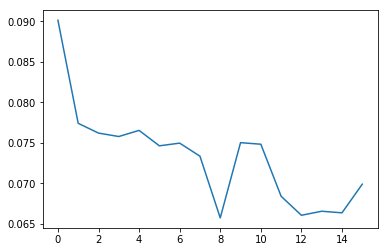

으------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------ᅵ다.<eos>
으ᅵ다.<eos>
근로 시간이 단축되면 근로 환경과 근로자들의 삶의 질이 개선될 것입니다.<eos>------------------


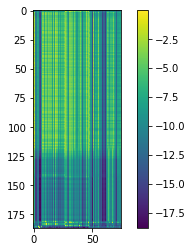

-------------------------------------------------------------------------------------------------------
08-31 13:56:31
Mean Loss: 0.06892932024885735
-------------------------------------------------------------------------------------------------------
08-31 13:56:52
Mean Loss: 0.06716177694094647
-------------------------------------------------------------------------------------------------------
08-31 13:57:13
Mean Loss: 0.06604489441266088
-------------------------------------------------------------------------------------------------------
08-31 13:57:34
Mean Loss: 0.07528299699046397
-------------------------------------------------------------------------------------------------------
08-31 13:57:56
Mean Loss: 0.07514480850529301
-------------------------------------------------------------------------------------------------------
08-31 13:58:17
Mean Loss: 0.07131984483453509
----------------------------------------------------------------------------------------------------

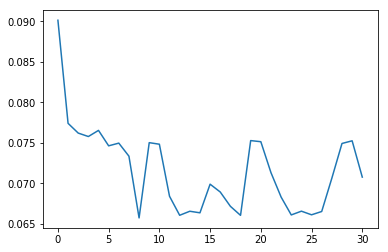

아--------으--으---ᅳ---ᅳ---아---ᅳ--으--으---ᅳ--으--아--ᅳ--으--으--으--으--으--으---ᅳ---ᅳ--으--으--으--아--아---ᅳ--아--ᄋ--으--으--아---------------------------------ᄂᆻ다.<eos>
아으으ᅳᅳ아ᅳ으으ᅳ으아ᅳ으으으으으으ᅳᅳ으으으아아ᅳ아ᄋ으으아ᄂᆻ다.<eos>
제가 그 오페라의 주연을 따냈다는 얘기를 들었을 때 저는 정말 믿기지가 않았어요.<eos>------------


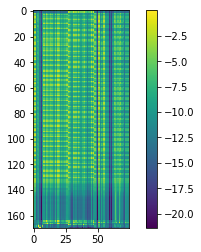

-------------------------------------------------------------------------------------------------------
08-31 14:01:50
Mean Loss: 0.07569076444049515
-------------------------------------------------------------------------------------------------------
08-31 14:02:12
Mean Loss: 0.07505462708114931
-------------------------------------------------------------------------------------------------------
08-31 14:02:33
Mean Loss: 0.06889765799501064
-------------------------------------------------------------------------------------------------------
08-31 14:02:55
Mean Loss: 0.06773175721716891
-------------------------------------------------------------------------------------------------------
08-31 14:03:16
Mean Loss: 0.06672786938305847
-------------------------------------------------------------------------------------------------------
08-31 14:03:37
Mean Loss: 0.0684031008766608
-----------------------------------------------------------------------------------------------------

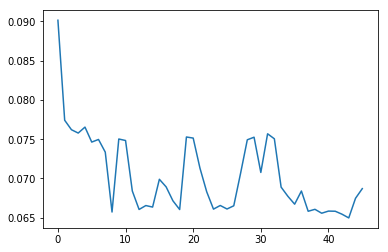

아-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------됴.<eos>
아됴.<eos>
기증품이 계속 들어오면서 우리는 저장 공간이 부족하다는 사실을 깨달았어요.<eos>----------------


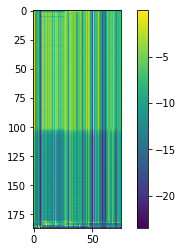

-------------------------------------------------------------------------------------------------------
08-31 14:07:10
Mean Loss: 0.07598853039406464
-------------------------------------------------------------------------------------------------------
08-31 14:07:31
Mean Loss: 0.07761175919080653
-------------------------------------------------------------------------------------------------------
08-31 14:07:52
Mean Loss: 0.07517851346263023
-------------------------------------------------------------------------------------------------------
08-31 14:08:14
Mean Loss: 0.0713354021629866
-------------------------------------------------------------------------------------------------------
08-31 14:08:35
Mean Loss: 0.06635812811777682
-------------------------------------------------------------------------------------------------------
08-31 14:08:56
Mean Loss: 0.06543376396808244
-----------------------------------------------------------------------------------------------------

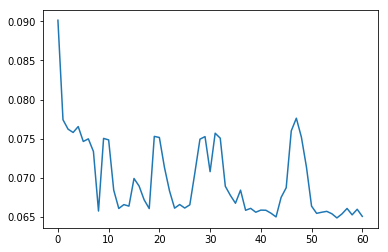

아-으--으--으--으--아---ᄋ---아--아--아--아---아--아--아--아-------아--ᄋ---아---아------아--아---ᄋ------아--ᄋ----------------ᅡ---아---ᅡ--------------------------------다.<eos>
아으으으으아ᄋ아아아아아아아아아ᄋ아아아아ᄋ아아아ᅡ다.<eos>
여러분은 이곳에서 장미, 백합, 튤립 등 다양한 종류의 꽃들을 보실 수 있습니다.<eos>----------


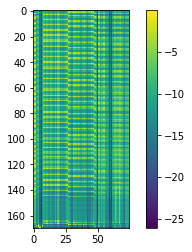

-------------------------------------------------------------------------------------------------------
08-31 14:12:29
Mean Loss: 0.06464982484371726
-------------------------------------------------------------------------------------------------------
08-31 14:12:50
Mean Loss: 0.0651191663791875
-------------------------------------------------------------------------------------------------------
08-31 14:13:12
Mean Loss: 0.06608913871360364
-------------------------------------------------------------------------------------------------------
08-31 14:13:34
Mean Loss: 0.06421788710109795
-------------------------------------------------------------------------------------------------------
08-31 14:13:55
Mean Loss: 0.06395834909435066
-------------------------------------------------------------------------------------------------------
08-31 14:14:16
Mean Loss: 0.06385988531588763
-----------------------------------------------------------------------------------------------------

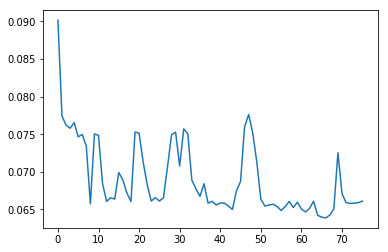

아-느---으---아--으---ᄋ--ᄋ---아--아----아--아---아----아--아---아----아---아---아---아---아---아----아---아----아-------아-----아----아---아-------------------------ᅵ다.<eos>
아느으아으ᄋᄋ아아아아아아아아아아아아아아아아아아아아아ᅵ다.<eos>
처음 이곳에 이사 왔을 때 걸어서 닿는 거리에 식료품 가게가 있다는 게 참 좋았어요.<eos>----------


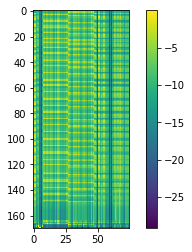

-------------------------------------------------------------------------------------------------------
08-31 14:17:49
Mean Loss: 0.06596646109650377
-------------------------------------------------------------------------------------------------------
08-31 14:18:09
Mean Loss: 0.06581396310800194
-------------------------------------------------------------------------------------------------------
08-31 14:18:30
Mean Loss: 0.06741258028482096
-------------------------------------------------------------------------------------------------------
08-31 14:18:51
Mean Loss: 0.0662953190322802
-------------------------------------------------------------------------------------------------------
08-31 14:19:13
Mean Loss: 0.06562142651317882
-------------------------------------------------------------------------------------------------------
08-31 14:19:34
Mean Loss: 0.06639448915750297
-----------------------------------------------------------------------------------------------------

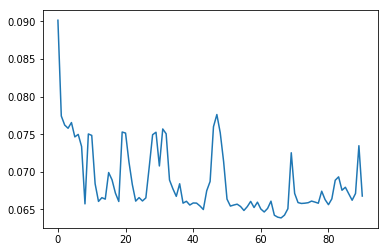

아-느---아---아---아--아------------아---아--ᄋ---아--아-----아---아--아--아---아--아---아--아--ᄋ아--아----아--아--아-----아---아---아--아---ᄋ----아-----------------------------------ᅵ다.<eos>
아느아아아아아아ᄋ아아아아아아아아아아아아아아아아아아아ᄋ아ᅵ다.<eos>
많은 경우 추리 소설에서 배경이나 주인공의 직업은 구성에 있어 중요한 요소다.<eos>---------------


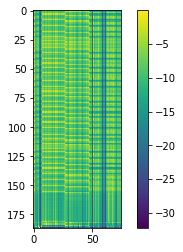

-------------------------------------------------------------------------------------------------------
08-31 14:23:04
Mean Loss: 0.06660228823769145
-------------------------------------------------------------------------------------------------------
08-31 14:23:25
Mean Loss: 0.06698439974965345
-------------------------------------------------------------------------------------------------------
08-31 14:23:46
Mean Loss: 0.06625561356390355
-------------------------------------------------------------------------------------------------------
08-31 14:24:07
Mean Loss: 0.06607978498724994
-------------------------------------------------------------------------------------------------------
08-31 14:24:28
Mean Loss: 0.06630962493878363
-------------------------------------------------------------------------------------------------------
08-31 14:24:49
Mean Loss: 0.06641203715365106
----------------------------------------------------------------------------------------------------

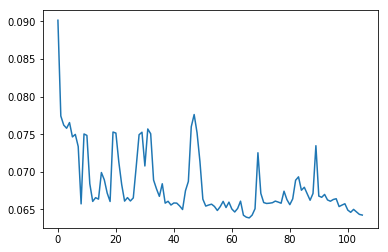

아-으--으--으--으--아ᅡ--아--아-ᄋ---아--아--아---아--아--아---아---아---아--아---아--아--아--아---아--아-아---------아-아----------------------------------------------다.<eos>
아으으으으아아아ᄋ아아아아아아아아아아아아아아아아아아아다.<eos>
혼날까 봐 거짓말을 했는데, 나중에 거짓말을 한 것 때문에 엄마한테 더 혼났어요.<eos>---------


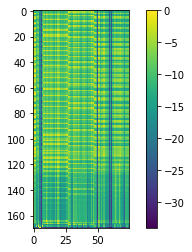

-------------------------------------------------------------------------------------------------------
08-31 14:28:21
Mean Loss: 0.06546590165070736
-------------------------------------------------------------------------------------------------------
08-31 14:28:42
Mean Loss: 0.06517481202073884
-------------------------------------------------------------------------------------------------------
08-31 14:29:02
Mean Loss: 0.06448969626248195
-------------------------------------------------------------------------------------------------------
08-31 14:29:23
Mean Loss: 0.06400680623351393
-------------------------------------------------------------------------------------------------------
08-31 14:29:44
Mean Loss: 0.06518515502479687
-------------------------------------------------------------------------------------------------------
08-31 14:30:06
Mean Loss: 0.06457040468945956
----------------------------------------------------------------------------------------------------

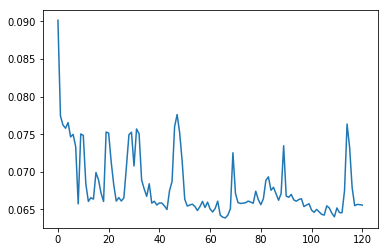

아-느---으---으---아---아---아---아--아---아---아---아----아----아---아---아---아---아---아---아--아---아----아-아---아---ᄋ------------------------------------------------------------다.<eos>
아느으으아아아아아아아아아아아아아아아아아아아아아ᄋ다.<eos>
보일러가 고장 났다는 초기 신호는 온수가 안 나오거나 난방이 안 될 때입니다.<eos>-----------------


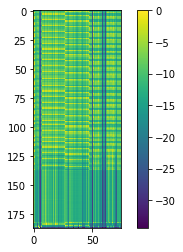

-------------------------------------------------------------------------------------------------------
08-31 14:33:34
Mean Loss: 0.06572275285444977
-------------------------------------------------------------------------------------------------------
08-31 14:33:55
Mean Loss: 0.06596189825651012
-------------------------------------------------------------------------------------------------------
08-31 14:34:16
Mean Loss: 0.0657616545480667
-------------------------------------------------------------------------------------------------------
08-31 14:34:37
Mean Loss: 0.06524158477214058
-------------------------------------------------------------------------------------------------------
08-31 14:34:57
Mean Loss: 0.06558877022862807
-------------------------------------------------------------------------------------------------------
08-31 14:35:18
Mean Loss: 0.06592552989803327
-----------------------------------------------------------------------------------------------------

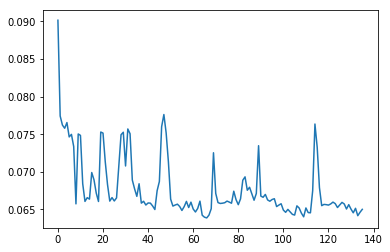

아-느--으--으---으--아---아-------아---아--아--아---아--아---아--아---아---아--아---아--아----ᅡ--아---아--아---아--아--아---------------------------------------------다.<eos>
아느으으으아아아아아아아아아아아아아아아ᅡ아아아아아아다.<eos>
저희 매장의 모든 품목이 이번 주에 최고 삼십 퍼센트까지 할인 판매를 합니다.<eos>-----------------


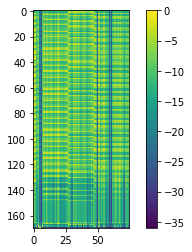

-------------------------------------------------------------------------------------------------------
08-31 14:38:45
Mean Loss: 0.0644961038972767
-------------------------------------------------------------------------------------------------------
08-31 14:39:06
Mean Loss: 0.0642339350446676
-------------------------------------------------------------------------------------------------------
08-31 14:39:26
Mean Loss: 0.06367402673595463
-------------------------------------------------------------------------------------------------------
08-31 14:39:47
Mean Loss: 0.06356193404315352
-------------------------------------------------------------------------------------------------------
08-31 14:40:08
Mean Loss: 0.06362654081543694
-------------------------------------------------------------------------------------------------------
08-31 14:40:28
Mean Loss: 0.06441142204793127
------------------------------------------------------------------------------------------------------

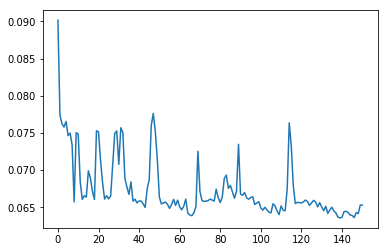

아-느--으---으--으---아---아--아------아-----아--아---아-------ᅡ--아---아-------아--아---아---아---아--아---아--아---아--아---아---아---아--아---아--아-------아---아------------------아.<eos>
아느으으으아아아아아아아ᅡ아아아아아아아아아아아아아아아아아아아아아.<eos>
국제연합의 공식 언어는 아랍어, 중국어, 영어, 불어, 러시아어, 스페인어이다.<eos>-----------------


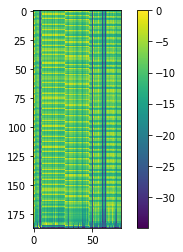

-------------------------------------------------------------------------------------------------------
08-31 14:43:55
Mean Loss: 0.06476685845535017
-------------------------------------------------------------------------------------------------------
08-31 14:44:16
Mean Loss: 0.06473338514807411
-------------------------------------------------------------------------------------------------------
08-31 14:44:36
Mean Loss: 0.06447246873946921
-------------------------------------------------------------------------------------------------------
08-31 14:44:57
Mean Loss: 0.06526911745664116
-------------------------------------------------------------------------------------------------------
08-31 14:45:17
Mean Loss: 0.06496958245956318
-------------------------------------------------------------------------------------------------------
08-31 14:45:38
Mean Loss: 0.06515051075740584
----------------------------------------------------------------------------------------------------

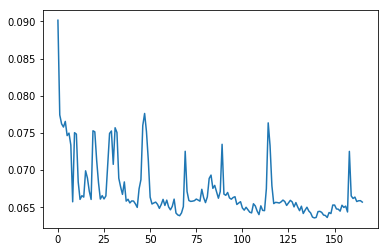

아-느----으---으---아----아---아---아----아----아---아---아----아---아---아---아----아----아---아-----아---아--아---아---ᅡ--아---아----ᄋ------------------------------다.<eos>
아느으으아아아아아아아아아아아아아아아아아아아ᅡ아아ᄋ다.<eos>
근로 시간이 단축되면 근로 환경과 근로자들의 삶의 질이 개선될 것입니다.<eos>------------------


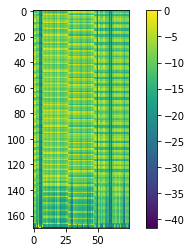

-------------------------------------------------------------------------------------------------------
08-31 14:49:05
Mean Loss: 0.0659490276900087
-------------------------------------------------------------------------------------------------------
08-31 14:49:26
Mean Loss: 0.06563858100515099
-------------------------------------------------------------------------------------------------------
08-31 14:49:46
Mean Loss: 0.06552844808983661
-------------------------------------------------------------------------------------------------------
08-31 14:50:07
Mean Loss: 0.06613856982600648
-------------------------------------------------------------------------------------------------------
08-31 14:50:27
Mean Loss: 0.06567996064738527
-------------------------------------------------------------------------------------------------------
08-31 14:50:48
Mean Loss: 0.06569038310347235
-----------------------------------------------------------------------------------------------------

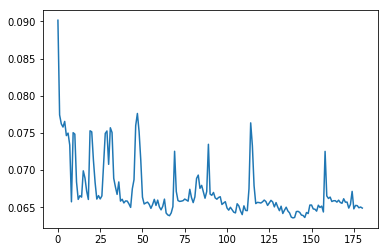

아-느--으---으---으---아--아--아--아--아-------아--아---아------아--아---아---아---아---아---아---아--아---아---아---ᅡ---아---ᄋ--------------------------------------------------------다.<eos>
아느으으으아아아아아아아아아아아아아아아아아아아ᅡ아ᄋ다.<eos>
근로 시간이 단축되면 근로 환경과 근로자들의 삶의 질이 개선될 것입니다.<eos>------------------


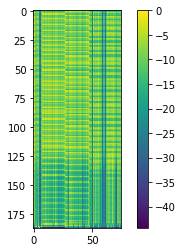

-------------------------------------------------------------------------------------------------------
08-31 14:54:14
Mean Loss: 0.065054600376927
-------------------------------------------------------------------------------------------------------
08-31 14:54:34
Mean Loss: 0.06489454140380936
-------------------------------------------------------------------------------------------------------
08-31 14:54:55
Mean Loss: 0.06477592033802118
-------------------------------------------------------------------------------------------------------
08-31 14:55:15
Mean Loss: 0.06485246924657903
-------------------------------------------------------------------------------------------------------
08-31 14:55:36
Mean Loss: 0.06504640812182423
-------------------------------------------------------------------------------------------------------
08-31 14:55:56
Mean Loss: 0.0650828879847965
-------------------------------------------------------------------------------------------------------

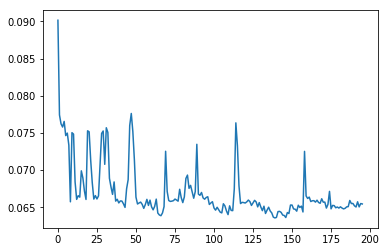

아-느--으---으---으---아----아----아---아----아---아--아---아----아---아---아--아---아--아-아-아--아----아---아---아----ᄋ--------------------------------------------------------------다.<eos>
아느으으으아아아아아아아아아아아아아아아아아아아아ᄋ다.<eos>
감옥에 몇 년간 형을 살고 나온 후 그는 착실하게 살겠다고 마음먹었다.<eos>--------------------


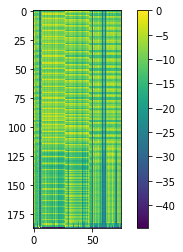

-------------------------------------------------------------------------------------------------------
08-31 14:59:22
Mean Loss: 0.066834503306353
-------------------------------------------------------------------------------------------------------
08-31 14:59:44
Mean Loss: 0.07837461912178653
-------------------------------------------------------------------------------------------------------
08-31 15:00:04
Mean Loss: 0.0714690594617282
-------------------------------------------------------------------------------------------------------
08-31 15:00:25
Mean Loss: 0.06921733358732728
-------------------------------------------------------------------------------------------------------
08-31 15:00:45
Mean Loss: 0.0674436893457809
-------------------------------------------------------------------------------------------------------
08-31 15:01:06
Mean Loss: 0.06749180127767358
-------------------------------------------------------------------------------------------------------


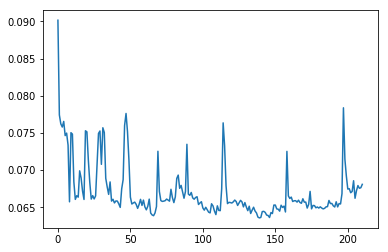

아-느--아--아---아--아-아--아-아----ᅡ-아---아---ᅡ--ᅡ-아-아-아--아---ᅡ-아----아-아-아--아---아--ᅡ---ᅡ------아-아--아----ᅡ--아-아--아----아---아---ᄋ--------------------다.<eos>
아느아아아아아아아ᅡ아아ᅡᅡ아아아아ᅡ아아아아아아ᅡᅡ아아아ᅡ아아아아아ᄋ다.<eos>
우리는 외국인 근로자들의 권익을 보호하기 위해 계속해서 최선을 다할 것입니다.<eos>--------------


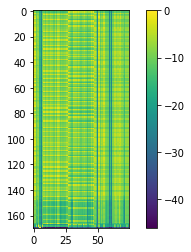

-------------------------------------------------------------------------------------------------------
08-31 15:04:32
Mean Loss: 0.06765323582899888
-------------------------------------------------------------------------------------------------------
08-31 15:04:52
Mean Loss: 0.06681902419386261
-------------------------------------------------------------------------------------------------------
08-31 15:05:13
Mean Loss: 0.06624362909597338
-------------------------------------------------------------------------------------------------------
08-31 15:05:33
Mean Loss: 0.06603368764261389
-------------------------------------------------------------------------------------------------------
08-31 15:05:54


In [0]:
EPOCH = 3 * 60 * 4
    
try:
    net.load('gdrive/My Drive/korean-single-speaker-speech-dataset/kss/model_saved/CTC_1024H_3')
except:
    print("Loading Error")
    
for epoch in range(EPOCH):
    
    preloader.initialize_batch()
    counter = 0
    loss_list = list()
    print(datetime.now().strftime('%m-%d %H:%M:%S'))
    
    while preloader.end_flag == False:
        tensor_input, ground_truth, loss_mask, length_list = preloader.get_batch()

        pred_tensor, loss = net.train(tensor_input.to(device), ground_truth.to(device), loss_mask.to(device), length_list.to(device))
        
        counter += 1
        loss_list.append(loss)

    print("Mean Loss: {}".format(np.mean(np.asarray(loss_list))))
    loss_history.append(np.mean(np.asarray(loss_list)))
    net.save('gdrive/My Drive/korean-single-speaker-speech-dataset/kss/model_saved/CTC_1024H_3')
    np.save('gdrive/My Drive/korean-single-speaker-speech-dataset/kss/model_saved/loss_history_3.npy', loss_history)
        
    
    if ((epoch != 0) and (epoch % 15 == 0)):
        
        plt.figure()
        plt.plot(loss_history)
        plt.show()
        
        _, index = pred_tensor[:, 0, :].max(-1)

        sentence = tokenizer.num2word(index.view(-1))
        print(''.join(sentence))
        index_ = Decode_CTC_Prediction(index)
        sentence_ = tokenizer.num2word(index_)
        print(''.join(sentence_))
        true_sentence = tokenizer.num2word(ground_truth[0, :].detach().numpy().astype(int))
        print(''.join(true_sentence))

        plt.figure()
        plt.imshow(pred_tensor[:, 0, :].detach().cpu().numpy())
        plt.colorbar()
        plt.show()
                        
    print("-------------------------------------------------------------------------------------------------------")